In [1]:
#Transfer leraning with Tensorfow part 3 : Scaling up
!nvidia-smi

Sat Feb  3 13:13:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P3              17W /  30W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
# creating helper functions
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir,compare_historys,make_confusion_matrix

In [2]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [3]:
#Setup Data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=IMG_SIZE,shuffle=False) # dont shuffle test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
#create checkpoint callback
checkpoint_path = "transfer_learning/101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,)

In [7]:
#create data augmentation layer to incorporate it into model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


#setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) #Rescale input of images between 0 & 1 , required for model like resnet50
] ,name = "data_augmentation")

In [8]:
# setup the base model and freeze its layers
#005 Creating a headless EfficientNetB0 model with data augmentation built in
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable=False

#Setup model architecuture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x= data_augmentation(inputs) #augment images (only happens during training phase
x = base_model(x,training=False) # put the base model in inference mode so weights are frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x) # in case of models (like sequential) input go inside model in layers inputs go outside model
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [9]:
# get summary of model created
model.summary() # transfer learning feature extraction model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [10]:
#006 Fitting and evaluating our biggest transfer learning model yet
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 132s 513ms/step - loss: 3.5540 - accuracy: 0.2312 - val_loss: 2.6853 - val_accuracy: 0.4216
Epoch 2/5
237/237 [==============================] - 107s 448ms/step - loss: 2.4310 - accuracy: 0.4486 - val_loss: 2.1973 - val_accuracy: 0.4873
Epoch 3/5
237/237 [==============================] - 67s 281ms/step - loss: 2.0536 - accuracy: 0.5163 - val_loss: 2.0283 - val_accuracy: 0.5056
Epoch 4/5
237/237 [==============================] - 65s 272ms/step - loss: 1.8441 - accuracy: 0.5564 - val_loss: 1.8842 - val_accuracy: 0.5310
Epoch 5/5
237/237 [==============================] - 64s 269ms/step - loss: 1.6788 - accuracy: 0.5929 - val_loss: 1.7901 - val_accuracy: 0.5487


In [11]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 56s 71ms/step - loss: 1.6427 - accuracy: 0.5691


[1.6427478790283203, 0.5690693259239197]

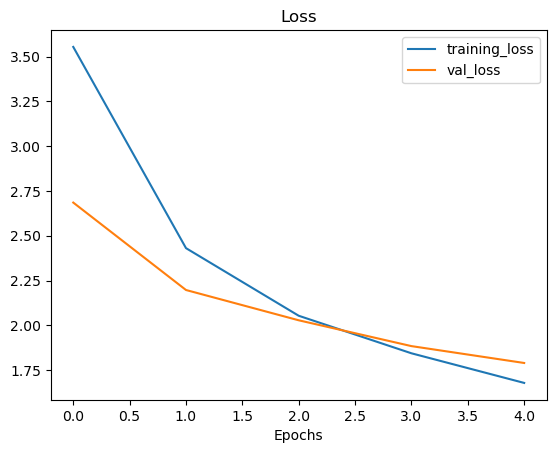

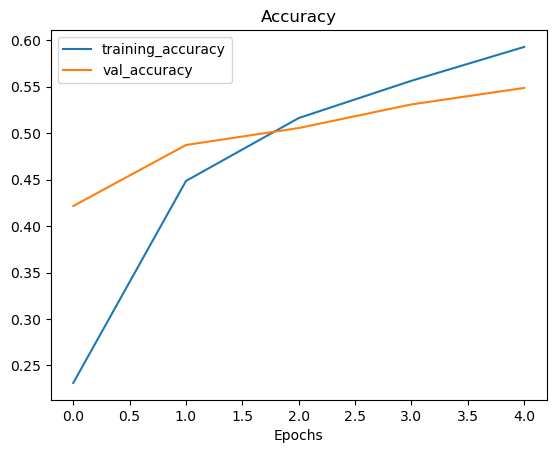

In [12]:
plot_loss_curves(history_all_classes_10_percent)

In [13]:
#007 Unfreezing some layers in our base model to prepare for fine-tuning
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last file
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [14]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [15]:
#008 Fine-tuning our feature extraction model and evaluating its performance
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 72s 278ms/step - loss: 1.4900 - accuracy: 0.6269 - val_loss: 1.7834 - val_accuracy: 0.5336
Epoch 6/10
237/237 [==============================] - 67s 284ms/step - loss: 1.3850 - accuracy: 0.6479 - val_loss: 1.7959 - val_accuracy: 0.5331
Epoch 7/10
237/237 [==============================] - 66s 277ms/step - loss: 1.3170 - accuracy: 0.6583 - val_loss: 1.7819 - val_accuracy: 0.5347
Epoch 8/10
237/237 [==============================] - 67s 281ms/step - loss: 1.2725 - accuracy: 0.6679 - val_loss: 1.7546 - val_accuracy: 0.5471
Epoch 9/10
237/237 [==============================] - 67s 283ms/step - loss: 1.2267 - accuracy: 0.6767 - val_loss: 1.7759 - val_accuracy: 0.5389
Epoch 10/10
237/237 [==============================] - 66s 280ms/step - loss: 1.2017 - accuracy: 0.6857 - val_loss: 1.7559 - val_accuracy: 0.5413


In [16]:
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results

790/790 [==============================] - 619s 785ms/step - loss: 1.5043 - accuracy: 0.5981


[1.5042568445205688, 0.5980989933013916]

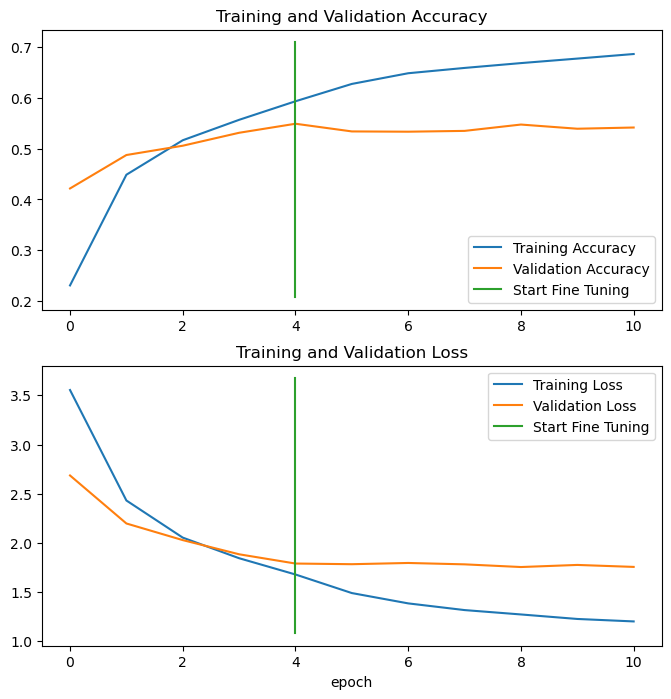

In [17]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [18]:
#009 Saving and loading our trained model
#Saving and loading our model
#model.save("saved_models/101_food_classes_10_percent")
#model.save("saved_models/101_food_classes_10_percent")

INFO:tensorflow:Assets written to: saved_models/101_food_classes_10_percent\assets


INFO:tensorflow:Assets written to: saved_models/101_food_classes_10_percent\assets


In [4]:
loaded_model = tf.keras.models.load_model("saved_models/101_food_classes_10_percent")

In [5]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 62s 73ms/step - loss: 1.5043 - accuracy: 0.5981


[1.5042568445205688, 0.5980989933013916]

In [6]:
#010 Downloading a pretrained model to make and evaluate predictions with
#Evaluating performance of the big model across all different classes
model = tf.keras.models.load_model("saved_models/06_101_food_class_10_percent_saved_big_dog_model")

import tensorflow as tf

In [7]:
#evaluate the downloaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 62s 77ms/step - loss: 1.8019 - accuracy: 0.6077


[1.8019390106201172, 0.6077227592468262]

In [ ]:
#011 Making predictions with our trained model on 25,250 test samples

In [8]:
#Making predictions with our trained models
preds_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 59s 73ms/step


In [10]:
preds_probs.shape

(25250, 101)

In [11]:
# getting the pred classes of each labels
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [12]:
#012 Unravelling our test dataset for comparing ground truth labels to predictions
# Unbatch the dataset test_data
y_labels = []
for images,labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
#013 Confirming our model's predictions are in the same order as the test labels
results_downloaded_model

[1.8019390106201172, 0.6077227592468262]

In [15]:
#using sklearn accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077227722772277

In [16]:
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

In [20]:
#014 Creating a confusion matrix for our model's 101 different classes
#get a list of class names
class_names = test_data.class_names
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [21]:
#015 Evaluating every individual class in our dataset
#Sklearn has a helpful funtion for diff classification metrics
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.35      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.83      0.48      0.61       250
          12       0.53      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [22]:
#get a dict of the classification report
classification_repot_dict = classification_report(y_true=y_labels,y_pred=pred_classes,output_dict=True)
classification_repot_dict
# support is number of samples

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5605536332179931,
  'recall': 0.648,
  'f1-score': 0.601113172541744,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250.0},
 '5': {'precision': 0.3452685421994885,
  'recall': 0.54,
  'f1-score': 0.42121684867394693,
  'support': 250.0},
 '6': {'precision': 0.6700680272108843,
  'recall': 0.788,
  'f1-score': 0.724264705882353,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.386694386694386

In [23]:
class_f1_scores = {}
for k,v in classification_repot_dict.items():
    if k == "accuracy" : # stop once we get to accuracy key
        break
    else:
        class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.601113172541744,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.42121684867394693,
 'beignets': 0.724264705882353,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6126582278481012,
 'cannoli': 0.6146179401993355,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.37122969837587005,
 'cheese_plate': 0.5662650602409639,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7074569789674952,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.32499999999999996,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brule

In [25]:
# sort dict
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-scores":list(class_f1_scores.values())}).sort_values('f1-scores',ascending=False)

In [26]:
f1_scores

,class_names,f1-scores
33,edamame,0.935361
63,macarons,0.897275
75,pho,0.869903
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.335196
22,chocolate_mousse,0.325000
77,pork_chop,0.304850
39,foie_gras,0.296429


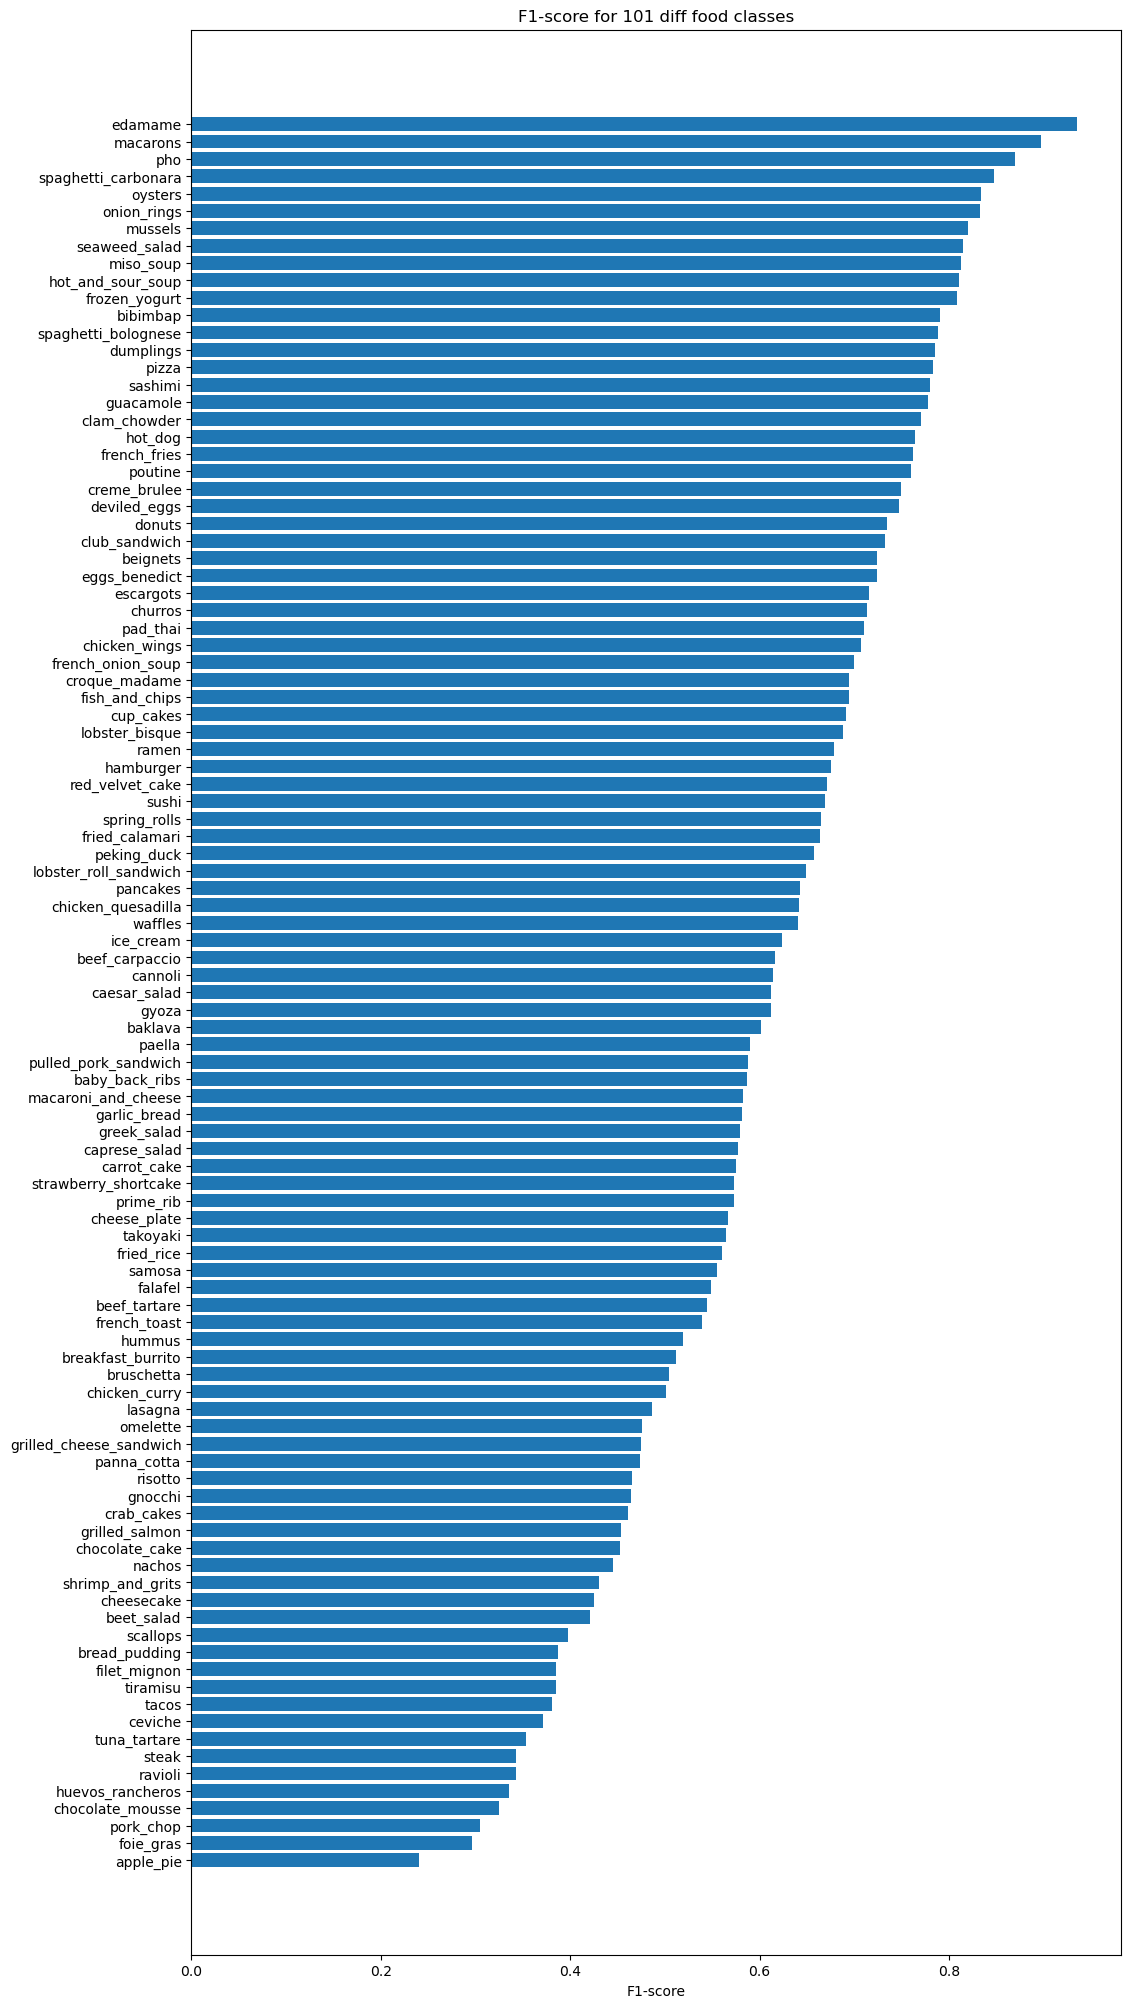

In [32]:
#016 Plotting our model's F1-scores for each separate class
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-scores"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 diff food classes")
ax.invert_yaxis()

In [ ]:
#017 Creating a function to load and prepare images for making predictions